In [1]:
import pandas as pd
import numpy as np

import collections

import string
import nltk
import unicodedata

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn import metrics
from sklearn.model_selection import train_test_split

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

#LSTM
import tensorflow as tf

from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.layers.embeddings import Embedding

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Upload dataset

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sample = pd.read_csv('sample_submission.csv')

In [3]:
df_train['dataset'] = 'train'
df_test['dataset'] = 'test'

In [4]:
df_aux = df_test.merge(df_sample, left_on='id', right_on='id')

In [5]:
df_aux.head()

,id,keyword,location,text,dataset,target
0,0,NaN,NaN,Just happened a terrible car crash,test,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",test,0
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",test,0
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,test,0
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,test,0


In [6]:
df = pd.concat([df_train, df_aux])

In [7]:
df.head()

,id,keyword,location,text,target,dataset
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,train
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,train
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,train
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,train
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,train


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10876 entries, 0 to 3262
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        10876 non-null  int64 
 1   keyword   10789 non-null  object
 2   location  7238 non-null   object
 3   text      10876 non-null  object
 4   target    10876 non-null  int64 
 5   dataset   10876 non-null  object
dtypes: int64(2), object(4)
memory usage: 594.8+ KB


## Knowing the dataset

In [9]:
df['target'].value_counts(normalize=True)

0    0.699246
1    0.300754
Name: target, dtype: float64

*Entendendo a distribuição das classes no dataset de treino: a base contém mais classes 0 do que 1 para a classificação dos desatres*

In [10]:
df_train['target'].value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

*Entretanto no dataset de treino as classes estão um pouco mais balanceadas do que no total. Vou usar o total para fazer os tratamentos de texto e vou usar apenas o dataset de treino para treinar o modelo*

In [11]:
df.drop('id', axis=1, inplace=True)

*O ID não contribui nada para o modelo, já que ele é único por tweet, por isso foi  excluído do modelo*

In [12]:
df['location'] = df['location'].apply(lambda x: str(x).replace('nan', 'Not identified'))

In [13]:
location = list(df['location'])

In [14]:
location_train = collections.Counter(location)
print(location_train)

Counter({'Not identified': 3638, 'USA': 141, 'New York': 109, 'United States': 65, 'London': 58, 'Canada': 42, 'Nigeria': 40, 'India': 35, 'Worldwide': 35, 'Los Angeles, CA': 34, 'UK': 33, 'Kenya': 32, 'Washington, DC': 31, 'Mumbai': 28, 'United Kingdom': 26, 'Australia': 25, 'California': 25, 'Los Angeles': 24, 'San Francisco': 23, 'Chicago, IL': 23, 'New York, NY': 22, 'California, USA': 21, 'NYC': 21, 'Florida': 21, 'San Francisco, CA': 20, 'Chicago': 17, 'Toronto': 16, 'Washington, D.C.': 16, 'Indonesia': 15, 'Ireland': 15, 'Everywhere': 15, 'ss': 14, 'Philippines': 14, 'Seattle': 14, 'Seattle, WA': 14, 'London, UK': 13, 'Texas': 13, 'New York City': 13, 'Earth': 13, 'Atlanta, GA': 13, 'Singapore': 13, 'Manchester': 13, 'Nashville, TN': 12, 'Denver, CO': 12, 'World': 12, 'Denver, Colorado': 12, 'London, England': 12, '304': 11, 'Memphis, TN': 11, 'Dallas, TX': 11, 'Calgary, Alberta': 11, 'Melbourne, Australia': 11, 'Paterson, New Jersey ': 11, 'San Diego, CA': 11, 'US': 10, 'Housto

*Olhando a freqüência da localidade das tweets, acredito que essa feature não vai contribuir para a previsão 
dos desastres, considerando que o dado está muito sujo, desnormalizado e não tem um padrão. Vou excluir essa feature do modelo*

In [15]:
df.drop('location', axis=1, inplace=True)

In [16]:
df['keyword'] = df['keyword'].apply(lambda x: str(x).replace('nan', 'Not identified'))

In [17]:
keyword = list(df['keyword'])

In [18]:
keyword_train = collections.Counter(keyword)
print(keyword_train)

Counter({'Not identified': 87, 'ablaze': 50, 'accident': 50, 'aftershock': 50, 'airplane%20accident': 50, 'ambulance': 50, 'annihilated': 50, 'annihilation': 50, 'apocalypse': 50, 'armageddon': 50, 'army': 50, 'arson': 50, 'arsonist': 50, 'attack': 50, 'attacked': 50, 'avalanche': 50, 'bioterror': 50, 'bioterrorism': 50, 'blaze': 50, 'blazing': 50, 'bleeding': 50, 'blew%20up': 50, 'blight': 50, 'blizzard': 50, 'blood': 50, 'bloody': 50, 'blown%20up': 50, 'body%20bag': 50, 'body%20bagging': 50, 'body%20bags': 50, 'bomb': 50, 'bombed': 50, 'bridge%20collapse': 50, 'buildings%20burning': 50, 'buildings%20on%20fire': 50, 'burned': 50, 'burning': 50, 'burning%20buildings': 50, 'casualties': 50, 'casualty': 50, 'catastrophe': 50, 'catastrophic': 50, 'cliff%20fall': 50, 'collapse': 50, 'collapsed': 50, 'collide': 50, 'collided': 50, 'crash': 50, 'crashed': 50, 'crush': 50, 'crushed': 50, 'curfew': 50, 'cyclone': 50, 'damage': 50, 'danger': 50, 'dead': 50, 'death': 50, 'deaths': 50, 'debris': 

*A feature de keyword acredito que tenha mais relevancia para o modelo, os termos estão normalizados e apresentam uma distribuição mais uniforme.*

In [19]:
keyword_train = dict(keyword_train)

In [20]:
df_keyword_train = pd.Series(keyword_train)

In [21]:
df_keyword_train = df_keyword_train.sort_values(ascending=False)

In [22]:
df_keyword_train.head()

Not identified    87
drowned           50
drought           50
displaced         50
disaster          50
dtype: int64

In [23]:
df_train_1 = df[df['target'] == 1]

In [24]:
keyword_1 = list(df_train_1['keyword'])

In [25]:
keyword_train_1 = collections.Counter(keyword_1)
print(keyword_train_1)

Counter({'Not identified': 42, 'derailment': 39, 'outbreak': 39, 'wreckage': 39, 'debris': 37, 'oil%20spill': 37, 'typhoon': 37, 'evacuated': 32, 'rescuers': 32, 'suicide%20bomb': 32, 'suicide%20bombing': 32, 'nuclear%20disaster': 31, 'razed': 31, 'airplane%20accident': 30, 'earthquake': 30, 'suicide%20bomber': 30, 'bridge%20collapse': 29, 'collision': 29, 'wildfire': 29, 'buildings%20on%20fire': 28, 'casualties': 28, 'drought': 28, 'evacuation': 28, 'mass%20murder': 28, 'sandstorm': 28, 'bombing': 27, 'devastation': 27, 'forest%20fires': 27, 'hostages': 27, 'sinkhole': 27, 'wild%20fires': 27, 'deaths': 26, 'derailed': 26, 'displaced': 26, 'famine': 26, 'fatal': 26, 'fatalities': 26, 'floods': 26, 'thunderstorm': 26, 'violent%20storm': 26, 'wounded': 26, 'attack': 25, 'evacuate': 25, 'flooding': 25, 'heat%20wave': 25, 'massacre': 25, 'accident': 24, 'buildings%20burning': 24, 'dust%20storm': 24, 'hailstorm': 24, 'injured': 24, 'terrorism': 24, 'collided': 23, 'rioting': 23, 'structural

In [26]:
keyword_train_1 = dict(keyword_train_1)

In [27]:
df_keyword_train_1 = pd.Series(keyword_train_1)

In [28]:
df_keyword_train_1 = df_keyword_train_1.sort_values(ascending=False)

In [29]:
df_keyword_train = df_keyword_train.to_frame()

In [30]:
df_keyword_train = df_keyword_train.reset_index()

In [31]:
df_keyword_train.head()

,index,0
0,Not identified,87
1,drowned,50
2,drought,50
3,displaced,50
4,disaster,50


In [32]:
df_keyword_train.columns = ['keyword', 'frequency_total']

In [33]:
df_keyword_train_1 = df_keyword_train_1.to_frame()

In [34]:
df_keyword_train_1 = df_keyword_train_1.reset_index()

In [35]:
df_keyword_train_1.columns = ['keyword', 'frequency']

In [36]:
df_keyword_train_1.head()

,keyword,frequency
0,Not identified,42
1,wreckage,39
2,derailment,39
3,outbreak,39
4,debris,37


In [37]:
df_keyword_prob = df_keyword_train.merge(df_keyword_train_1, left_on='keyword', right_on='keyword')

In [38]:
df_keyword_prob.head()

,keyword,frequency_total,frequency
0,Not identified,87,42
1,drowned,50,15
2,drought,50,28
3,displaced,50,26
4,disaster,50,15


In [39]:
df_keyword_prob['prob'] =  df_keyword_prob['frequency']/df_keyword_prob['frequency_total']

In [40]:
df_keyword_prob.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221 entries, 0 to 220
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   keyword          221 non-null    object 
 1   frequency_total  221 non-null    int64  
 2   frequency        221 non-null    int64  
 3   prob             221 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 8.6+ KB


In [41]:
df_keyword_prob.head()

,keyword,frequency_total,frequency,prob
0,Not identified,87,42,0.482759
1,drowned,50,15,0.300000
2,drought,50,28,0.560000
3,displaced,50,26,0.520000
4,disaster,50,15,0.300000


*Probabilidade de um tweet ser um desatre real de acordo com a palavra chave, lembrando que aqui está sendo considerada o dataset de treino e test*

## Preprocessing

In [42]:
df['keyword_text'] = df['keyword'] + ' ' + df['text']

In [43]:
df.head()

,keyword,text,target,dataset,keyword_text
0,Not identified,Our Deeds are the Reason of this #earthquake M...,1,train,Not identified Our Deeds are the Reason of thi...
1,Not identified,Forest fire near La Ronge Sask. Canada,1,train,Not identified Forest fire near La Ronge Sask....
2,Not identified,All residents asked to 'shelter in place' are ...,1,train,Not identified All residents asked to 'shelter...
3,Not identified,"13,000 people receive #wildfires evacuation or...",1,train,"Not identified 13,000 people receive #wildfire..."
4,Not identified,Just got sent this photo from Ruby #Alaska as ...,1,train,Not identified Just got sent this photo from R...


In [44]:
df['keyword_text'] = df['keyword_text'].apply(lambda x: x.lower())

In [45]:
df['keyword_text'] = df['keyword_text'].str.replace('[^\w\s]','')

In [46]:
df.head()

,keyword,text,target,dataset,keyword_text
0,Not identified,Our Deeds are the Reason of this #earthquake M...,1,train,not identified our deeds are the reason of thi...
1,Not identified,Forest fire near La Ronge Sask. Canada,1,train,not identified forest fire near la ronge sask ...
2,Not identified,All residents asked to 'shelter in place' are ...,1,train,not identified all residents asked to shelter ...
3,Not identified,"13,000 people receive #wildfires evacuation or...",1,train,not identified 13000 people receive wildfires ...
4,Not identified,Just got sent this photo from Ruby #Alaska as ...,1,train,not identified just got sent this photo from r...


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10876 entries, 0 to 3262
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   keyword       10876 non-null  object
 1   text          10876 non-null  object
 2   target        10876 non-null  int64 
 3   dataset       10876 non-null  object
 4   keyword_text  10876 non-null  object
dtypes: int64(1), object(4)
memory usage: 509.8+ KB


In [48]:
def remove_stopwords(word):
    
    normalize = ' '.join([w for w in word if w.lower() not in stopwords])
    return normalize

In [49]:
stopwords = list(set(stopwords.words('english')))

In [50]:
df['keyword_text'] = df['keyword_text'].apply(lambda x:remove_stopwords(word_tokenize(x)))

In [51]:
df['text_sentence'] = df['keyword_text'].apply(lambda x:text_to_word_sequence(x))

In [52]:
df['text_sentence'] = df['text_sentence'].apply(lambda x: str(x).replace('[','').replace(']',''))

In [53]:
df.head()

,keyword,text,target,dataset,keyword_text,text_sentence
0,Not identified,Our Deeds are the Reason of this #earthquake M...,1,train,identified deeds reason earthquake may allah f...,"'identified', 'deeds', 'reason', 'earthquake',..."
1,Not identified,Forest fire near La Ronge Sask. Canada,1,train,identified forest fire near la ronge sask canada,"'identified', 'forest', 'fire', 'near', 'la', ..."
2,Not identified,All residents asked to 'shelter in place' are ...,1,train,identified residents asked shelter place notif...,"'identified', 'residents', 'asked', 'shelter',..."
3,Not identified,"13,000 people receive #wildfires evacuation or...",1,train,identified 13000 people receive wildfires evac...,"'identified', '13000', 'people', 'receive', 'w..."
4,Not identified,Just got sent this photo from Ruby #Alaska as ...,1,train,identified got sent photo ruby alaska smoke wi...,"'identified', 'got', 'sent', 'photo', 'ruby', ..."


## Naive Bayes

In [54]:
df_aux1 = df[df['dataset'] == 'train']
X = df_aux1.text_sentence
y = df_aux1.target

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

*Fazendo a divisão do dataset em dados de treino e teste*

In [56]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

*Instanciando os modelos de CountVectorizer para converter os dados em um vetor de tokens, TfidfTransformer para a frequencia de termos e exclusão dos termos mais frequentes e o MultinomialNB, modelo de classificação Naive Bayes comumente utilizada em classificação de textos*

In [57]:
nb.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

*Treinando o modelo na base de treino*

In [58]:
def plot_metrics(X_test, y_test):
    
    #Predições
    y_pred = nb.predict(X_test)

    cm = metrics.confusion_matrix(y_test, y_pred)
    classes = list(range(0, 10))
    fig, ax = plt.subplots(figsize=(7, 7))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title="Matriz de Confusão",
           ylabel="Real",
           xlabel="Predito")

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], "d"),
                    ha="center", va="center",
                    color="white" if cm[i, j] > cm.max()/2. else "black")
    fig.tight_layout()
    plt.show()
    
    print('Accuracy %s' % (metrics.accuracy_score(y_pred, y_test)*100))

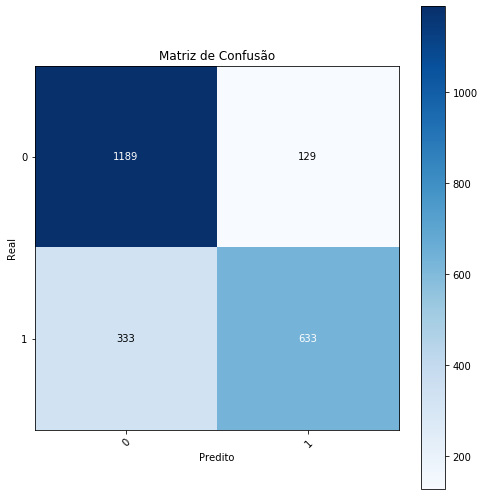

Accuracy 79.7723292469352


In [59]:
plot_metrics(X_test, y_test)

*O Naive Bayes utiliza de probabilidade, ou seja, ele classifica os itens baseado na probabilidade mais alta daquela texto pertencer ou não aquela classe. Para um modelo não parametrico e relativamente simples, teve uma acurácia bem legal aproximando de 80%*

## Preprocessing for LSTM

In [60]:
words = set(list(df_aux1['text_sentence']))
vocab_size = len(words)+1
print(vocab_size)

7515


In [61]:
df_aux1['text_one_hot'] = df_aux1['keyword_text'].apply(lambda x: one_hot(x, round(vocab_size))) 

In [62]:
df_aux1.head()

,keyword,text,target,dataset,keyword_text,text_sentence,text_one_hot
0,Not identified,Our Deeds are the Reason of this #earthquake M...,1,train,identified deeds reason earthquake may allah f...,"'identified', 'deeds', 'reason', 'earthquake',...","[6477, 3647, 6566, 3972, 6414, 4204, 6192, 1320]"
1,Not identified,Forest fire near La Ronge Sask. Canada,1,train,identified forest fire near la ronge sask canada,"'identified', 'forest', 'fire', 'near', 'la', ...","[6477, 3788, 281, 1829, 6138, 5972, 1217, 6767]"
2,Not identified,All residents asked to 'shelter in place' are ...,1,train,identified residents asked shelter place notif...,"'identified', 'residents', 'asked', 'shelter',...","[6477, 5281, 1598, 3436, 3340, 7240, 2066, 112..."
3,Not identified,"13,000 people receive #wildfires evacuation or...",1,train,identified 13000 people receive wildfires evac...,"'identified', '13000', 'people', 'receive', 'w...","[6477, 3943, 6777, 2444, 3885, 1123, 4, 4097]"
4,Not identified,Just got sent this photo from Ruby #Alaska as ...,1,train,identified got sent photo ruby alaska smoke wi...,"'identified', 'got', 'sent', 'photo', 'ruby', ...","[6477, 4926, 6518, 3886, 2697, 5469, 1247, 388..."


In [63]:
df_aux1['num_words'] = df_aux1['keyword_text'].apply(lambda x: len(x))

In [64]:
max_length_word = df_aux1['num_words'].max()

In [65]:
cod_tweets = list(df_aux1['text_one_hot'])

In [66]:
pad_tweets = pad_sequences(cod_tweets, maxlen=max_length_word, dtype='int32', padding='post')

In [67]:
target = list(df_aux1['target'])

In [68]:
X_train, X_test, Y_train, Y_test = train_test_split(pad_tweets, target, shuffle = True)

X_train = np.array(X_train) 
X_test = np.array(X_test)  
Y_train = np.array(Y_train)  
Y_test = np.array(Y_test) 

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(5709, 158) (5709,)
(1904, 158) (1904,)


## LSTM Model - Train

In [69]:
#Instanciando o modelo da LSTM
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=8, input_length=max_length_word))
model.add(Bidirectional(LSTM(64, return_sequences=True))),
model.add(Dropout(0.3, name = "Dropout"))
model.add(LSTM(64, return_sequences=True)),
model.add(Dense(1, activation='relu'))

In [70]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 158, 8)            60120     
_________________________________________________________________
bidirectional (Bidirectional (None, 158, 128)          37376     
_________________________________________________________________
Dropout (Dropout)            (None, 158, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 158, 64)           49408     
_________________________________________________________________
dense (Dense)                (None, 158, 1)            65        
Total params: 146,969
Trainable params: 146,969
Non-trainable params: 0
_________________________________________________________________
None


*Foi instaciado um modelo com 2 camadas LSTM, sendo uma Bidirecional com peso 64, uma camada Dropout 0.3 para evitar que a rede overfit e uma camada de ativação (Dense) com a função Relu, uma função que é linear para valores positivos e cancela valores negativos, e bastante usada em classificação de texto. A métrica utilizada de avaliação do modelo é a acurácia, a mesma utilizada para a avaliação do Naive Bayes e função de perda binary_crossentropy, considerando os valores da classe é 0 ou 1*

In [71]:
history = model.fit(X_train, Y_train, epochs=10, batch_size=64, validation_data=(X_test, Y_test))

Epoch 1/10
90/90 [==============================] - 32s 356ms/step - loss: 0.7596 - accuracy: 0.5596 - val_loss: 0.6932 - val_accuracy: 0.5804
Epoch 2/10
90/90 [==============================] - 32s 354ms/step - loss: 0.6925 - accuracy: 0.5607 - val_loss: 0.6853 - val_accuracy: 0.5804
Epoch 3/10
90/90 [==============================] - 33s 362ms/step - loss: 0.6867 - accuracy: 0.5683 - val_loss: 0.6855 - val_accuracy: 0.5884
Epoch 4/10
90/90 [==============================] - 32s 353ms/step - loss: 0.6803 - accuracy: 0.5702 - val_loss: 0.6725 - val_accuracy: 0.5926
Epoch 5/10
90/90 [==============================] - 32s 356ms/step - loss: 0.7002 - accuracy: 0.5834 - val_loss: 0.6667 - val_accuracy: 0.6053
Epoch 6/10
90/90 [==============================] - 32s 356ms/step - loss: 0.7021 - accuracy: 0.6064 - val_loss: 0.6783 - val_accuracy: 0.5993
Epoch 7/10
90/90 [==============================] - 32s 355ms/step - loss: 0.6379 - accuracy: 0.6593 - val_loss: 0.5823 - val_accuracy: 0.7252

In [72]:
#Avaliação do modelo
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 61.179322


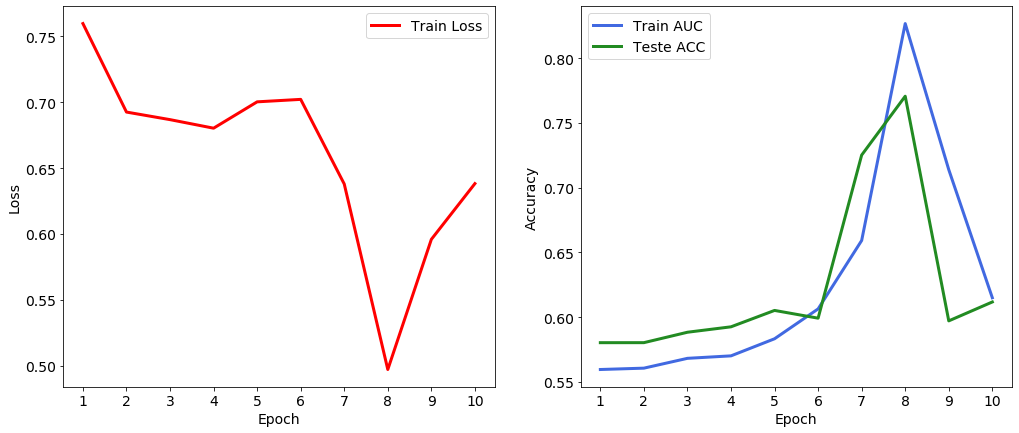

In [73]:
#Gera graficos do resultado do treino
mpl.rc("font", **{"size": 14})
fig, axes = plt.subplots(1, 2, figsize=(17, 7))

#Loss
axes[0].plot(range(1, len(history.history["loss"])+1), history.history["loss"], 
        label="Train Loss", color="red", lw=3)
axes[0].set_ylabel("Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_xticks(range(1, len(history.history["loss"])+1))
axes[0].legend()

#Accuracy
axes[1].plot(range(1, len(history.history["accuracy"])+1), history.history["accuracy"], 
        label="Train AUC", color="royalblue", lw=3)
axes[1].plot(range(1, len(history.history["val_accuracy"])+1), history.history["val_accuracy"], 
        label="Teste ACC", color="forestgreen", lw=3)
axes[1].set_ylabel("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_xticks(range(1, len(history.history["accuracy"])+1))
axes[1].legend()
plt.show()

*O LSTM é um modelo de rede neural recorrente, que conta com função de ativações dentre outros parametros de otimização, mesmo assim o modelo mais simples foi mais eficiente comparando os resultados, uma diferença de 22%*

## Test dataset

In [86]:
df_aux2 = df[df['dataset'] == 'test']

In [87]:
words = set(list(df_aux2['text_sentence']))
vocab_size = len(words)+1
print(vocab_size)

3245


In [88]:
df_aux2['text_one_hot'] = df_aux2['keyword_text'].apply(lambda x: one_hot(x, round(vocab_size))) 

In [89]:
df_aux2.head()

,keyword,text,target,dataset,keyword_text,text_sentence,text_one_hot
0,Not identified,Just happened a terrible car crash,0,test,identified happened terrible car crash,"'identified', 'happened', 'terrible', 'car', '...","[1341, 1072, 671, 384, 2157]"
1,Not identified,"Heard about #earthquake is different cities, s...",0,test,identified heard earthquake different cities s...,"'identified', 'heard', 'earthquake', 'differen...","[1341, 2467, 1910, 175, 160, 1238, 2629, 2630]"
2,Not identified,"there is a forest fire at spot pond, geese are...",0,test,identified forest fire spot pond geese fleeing...,"'identified', 'forest', 'fire', 'spot', 'pond'...","[1341, 1682, 2859, 2759, 3218, 1336, 884, 1307..."
3,Not identified,Apocalypse lighting. #Spokane #wildfires,0,test,identified apocalypse lighting spokane wildfires,"'identified', 'apocalypse', 'lighting', 'spoka...","[1341, 1147, 790, 1939, 999]"
4,Not identified,Typhoon Soudelor kills 28 in China and Taiwan,0,test,identified typhoon soudelor kills 28 china taiwan,"'identified', 'typhoon', 'soudelor', 'kills', ...","[1341, 1287, 1157, 1735, 1067, 2740, 711]"


In [90]:
df_aux2['num_words'] = df_aux2['keyword_text'].apply(lambda x: len(x))

In [91]:
max_length_word = df_aux2['num_words'].max()

In [92]:
cod_tweets_test = list(df_aux2['text_one_hot'])

In [93]:
pad_tweets_test = pad_sequences(cod_tweets_test, maxlen=max_length_word, dtype='int32', padding='post')

In [94]:
y_test = np.array(pad_tweets_test)
print('Format', y_test.shape)

Format (3263, 146)


## Predict

### LSTM

In [95]:
predict = model.predict_classes(y_test)

In [96]:
result_predict = pd.DataFrame(predict[0])

In [97]:
result_predict.head()

,0
0,0
1,0
2,0
3,0
4,0


In [98]:
df_result_aux = df_aux2.copy()

In [99]:
df_result_aux = df_aux2[['keyword','text']]

In [100]:
df_result_aux.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   keyword  3263 non-null   object
 1   text     3263 non-null   object
dtypes: object(2)
memory usage: 76.5+ KB


In [101]:
df_aux3 = pd.DataFrame(result_predict)

In [102]:
df_result = pd.concat([df_result_aux, df_aux3], axis=1, join='inner')

In [103]:
df_result.head()

,keyword,text,0
0,Not identified,Just happened a terrible car crash,0
1,Not identified,"Heard about #earthquake is different cities, s...",0
2,Not identified,"there is a forest fire at spot pond, geese are...",0
3,Not identified,Apocalypse lighting. #Spokane #wildfires,0
4,Not identified,Typhoon Soudelor kills 28 in China and Taiwan,0


In [104]:
df_result.columns = ['keyword', 'text', 'result']

In [105]:
df_result.head()

,keyword,text,result
0,Not identified,Just happened a terrible car crash,0
1,Not identified,"Heard about #earthquake is different cities, s...",0
2,Not identified,"there is a forest fire at spot pond, geese are...",0
3,Not identified,Apocalypse lighting. #Spokane #wildfires,0
4,Not identified,Typhoon Soudelor kills 28 in China and Taiwan,0


*A coluna result é o resultado para as previsões dos tweets da base de teste.*

In [106]:
df_result['result'].value_counts(normalize=True)

0    1.0
Name: result, dtype: float64

*Distribuição da previsão dos resultados com o modelo LSTM *

### Naive Bayes

In [107]:
df_aux1 = df[df['dataset'] == 'test']
X_predict = df_aux1.text_sentence
y_predict = df_aux1.target

In [108]:
predict_nb = nb.predict(X_predict)

In [109]:
print(predict_nb)

[1 1 1 ... 1 1 1]


In [110]:
df_nb = pd.DataFrame(predict_nb)

In [113]:
df_nb.head()

,0
0,1
1,1
2,1
3,1
4,1


In [114]:
df_result_nb = pd.concat([df_result_aux, df_nb], axis=1, join='inner')

In [115]:
df_result_nb.head()

,keyword,text,0
0,Not identified,Just happened a terrible car crash,1
1,Not identified,"Heard about #earthquake is different cities, s...",1
2,Not identified,"there is a forest fire at spot pond, geese are...",1
3,Not identified,Apocalypse lighting. #Spokane #wildfires,1
4,Not identified,Typhoon Soudelor kills 28 in China and Taiwan,1


In [116]:
df_result_nb.columns = ['keyword', 'text', 'result']

In [117]:
df_result_nb['result'].value_counts(normalize=True)

0    0.671468
1    0.328532
Name: result, dtype: float64

*Na predição o modelo do LSTM foi mais eficiente, acertou todos os registros enquanto o Naive Bayes, erros cerca de 33% dos registros.*